# <span style = "color:black">**Problem setting**

Deep Neural Network는 training중에 파라미터가 계속해서 학습되고 minibatch 각각의 분포가 다르기때문에  **hidden layer에 입력되는 input data의 분포가 계속해서 변화(internal covariate shift)**한다. 또한 hidden layer의 수가 많은 Deep nueral network에서는 여러번의 파라미터 연산이 반복되기 때문에 **깊이 위치하는 hidden layer일수록 이전에 학습했던 input의 분포와 많이 다른 분포를 가진 데이터가 입력**된다.이는 크게 두 가지의 문제를 가진다.

- 레이어의 파라미터 학습이 어려움
- Gradient vanishing or exploding

첫 번째는 학습하는데 어려움을 가진다는 것이다. 만약 input data의 분포가 고정되어있다면 그에 맞는 파라미터를 계속해서 학습하며 결과적으로 layer의 파라미터는 어떠한 값으로 수렴할 것이다.그러나 분포가 internal covariate shift가 (학습되는 파라미터로 인해)일어난다면 계속해서 새로운 분포에 맞춰서 파라미터를 수정해야 하기 때문에 학습하는데 어려움이 있다. 논문에서는 이를 좀 다른방식으로 설명하는데 training 셋의 분포와 testset의 분포가 같으면 학습이 잘되고 다르다면 학습이 안되는 것과 유사하다고 한다.

두 번째는 Gradient vanishing 또는 exploding이다.

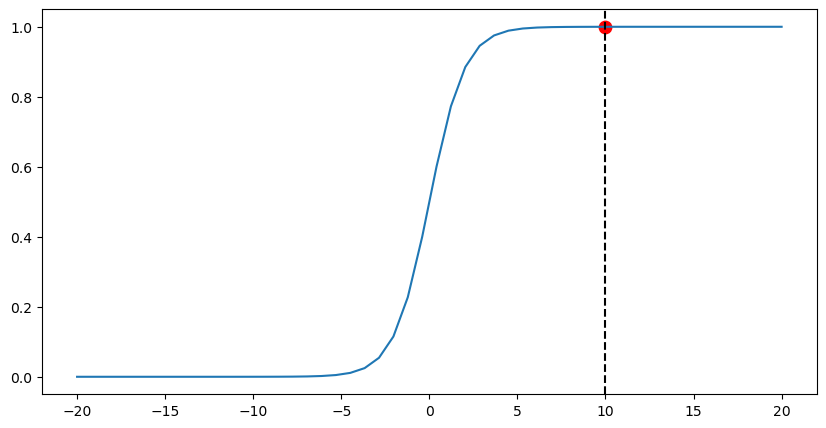

In [34]:
import matplotlib.pyplot as plt
import torch
plt.figure(figsize=(10,5))
sig = torch.nn.Sigmoid()
x = torch.linspace(-20,20,50)
z = sig(x)
point_x = torch.tensor(10)
point_z = sig(point_x)
plt.plot(x,z)
plt.scatter(point_x,point_z,s=80,color = "red")
plt.axvline(point_x,color="black",linestyle="--")


input의 분포의 변화로 인해 임의의 노드에서 시그모이드($g$)의 input $x = Wu + b$라고 가정해보자. 만약 $|x|$가 너무 커서 saturation regime에 존재한다면 $\frac{\partial{g}}{\partial{x}} \approx 0$이며 기울기가 vanishing되고 (이는 backpropagation되므로)파라미터의 업데이트가 일어나지 않게 된다.

위와 같은 문제점을 해결하기 위해 크게 다음과 같은 2가지의 방법이 시도되어왔다.

- lower learning rate => training time의 상승
- careful parameter initialization

위의 방법은 internal covariate shift를 어느정도 해결하긴 하지만 단점도 존재한다.(학습시간의 상승 등등 ...)

논문에서는 **internal covariate shift를 해결**하기 위해 **normalization for each training mini-batch(Batch Normalization)**을 수행한다.

# <span style = "color:black">**Normalization    via    Mini-Batch Statistics**

![](./BN%20algorithm.PNG)

먼저 notation과 내가 헷갈렸던 점을 잠깐 짚고 넘어간다.

- 논문을 기준으로 BN-layer는 parameter가 존재하는 FC-layer나 conv-layer와 activation function(layer)사이에 존재한다.(그러나 이는 비교적 자유로우며 후에 다시 나온다.)
-  $\mathcal{B} = \{x_{1...m}\}$는 data set에서 m개의 datapoint를 네트워크에 입력하면 어떤 hiddenlayer에 존재하는 임의의 노드 하나에서 activation function(layer)을 통과하기 전 m개의 값이 존재하는데 그 값들을 지칭한다. 그 사이의 값을 $x$라고 하면 $x_{1...m}$이 된다.
- $\mu_{\mathcal{B}}$는 minibatch를 구성하는 datapoint 각각을 네트워크에 입력하여 얻은 모든 $x$에 대한 평균을 의미한다.크기가 $m$인 minibatch에 대하여 $x_1,\dots,x_m$의 평균이다.
- $\sigma^2_{\mathcal{B}}$는 마찬가지로 minibatch여 얻은 $x$값들의 분산이다.
- $\hat{x_i}$는 minibatch에서 i-th datapoint에 위의 연산을 통해 얻은 값이다. $\mu_{\mathcal{B}}$와 $\sigma^2_{\mathcal{B}}$를 사용하므로 minibatch에서 계산한 모든$x$가 사용된다.
- $\hat{y_i}$는 learnable parameter인 $\gamma,\beta$를 추가한 값이다. 

평균~normalizae까지 살펴보면 minibatch를 하나의 단위로하여 activation function의 input인 $x$를 normalization하는 것을 의미한다. Problem setting에서 internal covariate shift가 일어나면서 나타나는 두 가지의 단점을 설명했다. normalization까지의 과정은 결국 normal gaussian distribution으로 바꿔서 **activation function으로 입력되는 input의 distribution을 가능한 비슷하게** 하고자 하는 것이다.

여기서 한 가지 중요한 사실은 normalization만 수행하면 network의 표현력을 감소시킨다는 것이다. sigmoid함수를 한 가지 예시로 들어보자. normalization으로 input data의 분포가 normal gaussian distribution가 되었다고 생각해보면 대부분 sigmoid의 linear한 영역에 존재할 것이다. 따라서 nonlinearity를 잃어버리게 된며 이는 네트워크의 표현력을 감소시키므로 좋지 않다.(linearity + nonlinearity는 DNN은 높은 표현력을 가짐을 기억하자) 그러므로, 이러한 점을 막기위해 여기에 추가적으로 학습이 가능한 파라미터 $\gamma$를 곱해주고 $\beta$를 더해줌으로서 optimal에 다가갈 수 있도록 분포를 학습을 통하여 shifting,scaling하여 network의 표현력을 유지한다.

예를 들어 학습된 $\gamma$,$\beta$는 다음과 같을 것이다.<br>
**(nonlinearity를 유지하는 것이 optimal한 경우)** <br>
$$\gamma \approx \sqrt{var[x]},\beta \approx \mathbb{E}[x] \rightarrow \hat{x_i}\approx x_i  $$
**(linearity를 얻는 것이 optimal한 경우)**<br>
$$\gamma \approx 1,\beta \approx 0 \rightarrow \hat{x_i} \approx \frac{x_i-\mu_\mathcal{B}}{\sqrt{\sigma_\mathcal{B}^2-\epsilon}}$$

정리하자면 BatchNormalization은 **Batch단위의 normalization,learnable parameter**를 추가하여**internal covariate shift를 막고 fixed된 distribution을 만듬**과 동시에 **nonlinearity를 유지**함으로서 **gradient vanishing(exploding),학습의 어려움,표현력의 감소**와 같은 문제를 해결했다고 할 수 있다.

# <span style = "color:black">**Training  and  Inference  with  Batch-Normalized Networks**

training에서는 minibatch단위로 평균,분산을 구하여 normalization할 수 있지만 test에서는 이와는 다르게 minibatch단위로 data가 입력되지 않으며 또한 입력되는 데이터만 사용하여 값을 예측하길 원한다. 따라서 **training에서 각각의 배치들로부터 얻은 평균들과 분산들을 저장**해놓고 **test에서는 이 값들로 다시 평균을 취하여 normalization**을 한다. 이때 단순한 평균을 취하는 것이 아니라 parameter가  어느정도 **학습된 상태에서 얻어진 minibatch들의 데이터를 더 많이 고려**하기 위해서 **movingaverage나 exponentialaverage를 사용**한다. movingaverage는 학습단계에서 얻어진 값(평균,분산)의 일부를 직접 지정하여 평균을 구하고 exponentialaverage는 어느정도 안정된 상태의 값들에 높은 가중치를 부여하여 평균,분산을 구한다.

\begin{aligned}
&\hat{x} = \frac{x - \mathbb{E}[x]}{\text{Var}[x] + \epsilon}\\
&y = \frac{\gamma}{\sqrt{\text{var}[x] + \epsilon}}\cdot x + (\beta - \frac{\gamma\mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}})\\
&\text{where }E[x] = E_\mathcal{B}[\mu_\mathcal{B}],\text{Var}[x] = \frac{m}{m-1}E_\mathcal{B}[\sigma_\mathcal{B}^2]
\end{aligned}

$\frac{m}{m-1}$은 unbiased estimate를 위하여 곱해진 값이며 $E_{\mathcal{B}}$는 moving average 또는 exponential average를 의미한다. test에서의 normalization은 단순히 linear transform으로 볼 수 있는데 이는 평균과 분산을 구하는 것이 아닌 training에서 구해놓은 값을 단순히 averaging한 고정된(fixed)값을 활용하기 때문이다. 